# Diagnose curse of dimensionality

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import statsmodels.api as sm
import linearmodels.iv.model as lm
from scipy import stats
from datetime import datetime


In [2]:
df = pd.read_csv('DiD_data.csv')
df.shape

(81560, 14)

In [3]:
df.head()

,rssd9001,rssd9999,bhc_avgtradingratio,treat_3_b_avg,after_DFA_1,dep_roa1,dep_leverage,dep_lnassets,dep_creditrisk_total3,dep_cir,dep_depositratio,dep_loans_REratio,dep_liquidity,dep_cpp_bankquarter
0,1020180,20040930,0.0,0,0,0.002772,0.081957,15.601202,0.013304,0.463811,0.561805,0.593738,0.024337,0
1,1020180,20041231,0.0,0,0,0.003045,0.082480,15.630583,0.009732,0.456392,0.557617,0.601763,0.025446,0
2,1020180,20050331,0.0,0,0,0.002616,0.082074,15.644925,0.011830,0.444011,0.556980,0.600700,0.025153,0
3,1020180,20050630,0.0,0,0,0.002647,0.081712,15.679702,0.013654,0.433771,0.571642,0.601042,0.023670,0
4,1020180,20050930,0.0,0,0,0.002867,0.082944,15.661868,0.012456,0.400985,0.577408,0.581438,0.029793,0


# Processing to create treatment col, process time col, and DiD col

In [4]:
# process time
df['time'] = pd.to_datetime(df['rssd9999'], format='%Y%m%d')

In [5]:
# assign treatment group, when bank has >3% at first timestep
df['treatment'] = 0 
mask = (df['treat_3_b_avg'] == 1) & (df['time'] == '2004-09-30')
banks_with_treatment = df.loc[mask, 'rssd9001'].unique()

df.loc[df['rssd9001'].isin(banks_with_treatment), 'treatment'] = 1


In [35]:
df['treatment'].value_counts(), df['treat_3_b_avg'].value_counts()


(treatment
 0    39498
 1      528
 Name: count, dtype: int64,
 treat_3_b_avg
 0    39399
 1      627
 Name: count, dtype: int64)

In [7]:
# create DiD parameter (when post treatment + treatment group
df['beta_para'] = df['after_DFA_1'] * df['treatment']

# NA handling

In [8]:
# check NAs
df.isna().sum()

rssd9001                     0
rssd9999                     0
bhc_avgtradingratio      40118
treat_3_b_avg                0
after_DFA_1                  0
dep_roa1                 24622
dep_leverage             24543
dep_lnassets             19789
dep_creditrisk_total3    37128
dep_cir                  39178
dep_depositratio          2388
dep_loans_REratio        37128
dep_liquidity            26401
dep_cpp_bankquarter          0
time                         0
treatment                    0
beta_para                    0
dtype: int64

In [9]:
df = df.dropna()
df.isna().sum()

rssd9001                 0
rssd9999                 0
bhc_avgtradingratio      0
treat_3_b_avg            0
after_DFA_1              0
dep_roa1                 0
dep_leverage             0
dep_lnassets             0
dep_creditrisk_total3    0
dep_cir                  0
dep_depositratio         0
dep_loans_REratio        0
dep_liquidity            0
dep_cpp_bankquarter      0
time                     0
treatment                0
beta_para                0
dtype: int64

# Parameter definition (KIV)

In [14]:
# parameter extraction
treat_3_b_avg = df['treat_3_b_avg']
after_DFA_1 = df['after_DFA_1']
time = df['time']

target = df['bhc_avgtradingratio']
X = df
X = X.drop(['rssd9999','bhc_avgtradingratio', 'after_DFA_1', 'treat_3_b_avg'], axis = 1)


# Frequency distrtibution of treat_3_b_avg and after_DFA_1 change across time
We observe that treat_3_avg does not remain constant, banks can change from 0 to 1 or 1 to 0

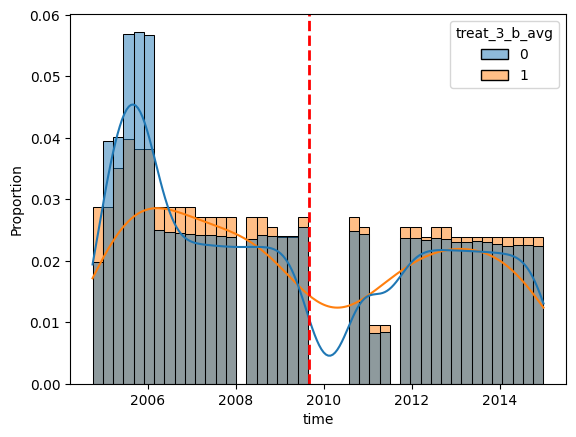

In [36]:
sns.histplot(treat_3_b_avg, x = time, hue = treat_3_b_avg, common_norm = False, stat = 'proportion', kde=True, bins = 40+4)
plt.axvline(x=pd.to_datetime('2009-09-01'), color='red', linestyle='dashed', linewidth=2)

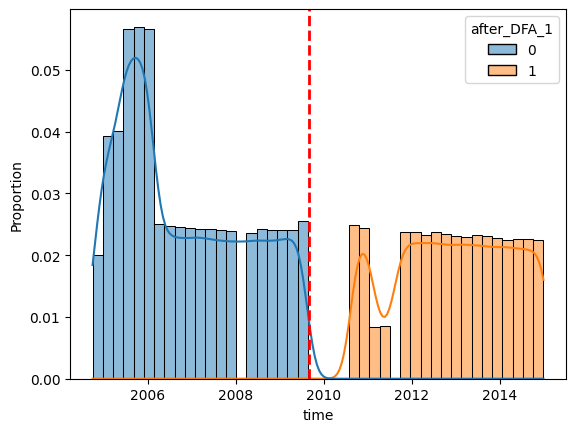

In [37]:
sns.histplot(after_DFA_1, x = time, hue = after_DFA_1, common_norm = True, stat = 'proportion', kde=True, bins = 40+4)
plt.axvline(x=pd.to_datetime('2009-09-01'), color='red', linestyle='dashed', linewidth=2)

<Axes: xlabel='time', ylabel='Proportion'>

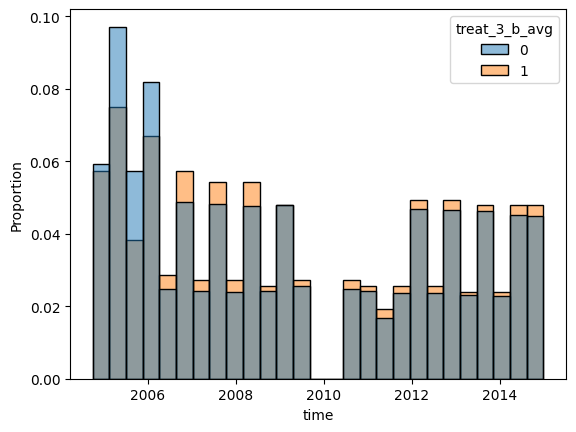

In [17]:
sns.histplot(target, x = time, hue = treat_3_b_avg, common_norm = False, stat = 'proportion')
# observe a slight slope downwards

In [18]:
X.head()

,rssd9001,dep_roa1,dep_leverage,dep_lnassets,dep_creditrisk_total3,dep_cir,dep_depositratio,dep_loans_REratio,dep_liquidity,dep_cpp_bankquarter,time,treatment,beta_para
0,1020180,0.002772,0.081957,15.601202,0.013304,0.463811,0.561805,0.593738,0.024337,0,2004-09-30,0,0
1,1020180,0.003045,0.082480,15.630583,0.009732,0.456392,0.557617,0.601763,0.025446,0,2004-12-31,0,0
2,1020180,0.002616,0.082074,15.644925,0.011830,0.444011,0.556980,0.600700,0.025153,0,2005-03-31,0,0
3,1020180,0.002647,0.081712,15.679702,0.013654,0.433771,0.571642,0.601042,0.023670,0,2005-06-30,0,0
4,1020180,0.002867,0.082944,15.661868,0.012456,0.400985,0.577408,0.581438,0.029793,0,2005-09-30,0,0


In [19]:
#slice function to extract 2 vars for given condition
def slice_plot(x1, x2, given, value):
    #input 2 vars x1,x2 in string format
    # for a condiction where variable given = value
    # slice = df[[x1,x2]] = df[given] == value

    extracted_data = df[df[given] == value][[x1, x2]]
    # slice = df[[x1,x2]]
    plt.figure(figsize=(8, 6))
    plt.plot(extracted_data[x1], extracted_data[x2])
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.title(f'Columns for condition: {given} = {value}')
    # plt.legend()
    plt.show()
    return extracted_data.head()

In [20]:
df_first_quarter = df[df['time'] == '2004-09-30']

In [21]:
treatment_df = df_first_quarter[ df_first_quarter['treat_3_b_avg'] == 1] 
control_df = df_first_quarter[ df_first_quarter['treat_3_b_avg'] == 0] 

treatment_df.shape, control_df.shape

((18, 17), (783, 17))

In [22]:
len(treatment_df.rssd9001.value_counts()), len(control_df.rssd9001.value_counts())
# define treatment as 29 banks and control as 2330 banks

(18, 783)

In [23]:
df_last_quarter = df[df['time'] == '2009-03-31']

In [24]:
treatment_df = df_last_quarter[ df_last_quarter['treat_3_b_avg'] == 1] 
control_df = df_last_quarter[ df_last_quarter['treat_3_b_avg'] == 0] 

treatment_df.shape, control_df.shape

((15, 17), (947, 17))

In [25]:
len(treatment_df.rssd9001.value_counts()), len(control_df.rssd9001.value_counts())
# define treatment as 27 banks and control as 2074 banks

(15, 947)

# OLS  df[['treatment', 'dep_roa1']]

In [26]:
# create model such that 
X = df[['treatment', 'dep_roa1']]
X = sm.add_constant(X)  # Adds a constant term to the model
Y = df['bhc_avgtradingratio']

# Fit the DiD model
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.309
Model:                             OLS   Adj. R-squared:                  0.309
Method:                  Least Squares   F-statistic:                     8965.
Date:                 Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                         18:36:07   Log-Likelihood:             1.0802e+05
No. Observations:                40026   AIC:                        -2.160e+05
Df Residuals:                    40023   BIC:                        -2.160e+05
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   8.75e-05     15.30

# OLS df[['beta_para','after_DFA_1','treatment', 'dep_roa1']]

In [27]:
# create model such that 
X = df[['beta_para','after_DFA_1','treatment', 'dep_roa1']]
X = sm.add_constant(X)  # Adds a constant term to the model
Y = df['bhc_avgtradingratio']

# Fit the DiD model
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.316
Model:                             OLS   Adj. R-squared:                  0.316
Method:                  Least Squares   F-statistic:                     4627.
Date:                 Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                         18:36:07   Log-Likelihood:             1.0822e+05
No. Observations:                40026   AIC:                        -2.164e+05
Df Residuals:                    40021   BIC:                        -2.164e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.000      9

# OLS df[['beta_para','after_DFA_1','treatment', ALL]] - 9 CVs

In [28]:
df.keys()

Index(['rssd9001', 'rssd9999', 'bhc_avgtradingratio', 'treat_3_b_avg',
       'after_DFA_1', 'dep_roa1', 'dep_leverage', 'dep_lnassets',
       'dep_creditrisk_total3', 'dep_cir', 'dep_depositratio',
       'dep_loans_REratio', 'dep_liquidity', 'dep_cpp_bankquarter', 'time',
       'treatment', 'beta_para'],
      dtype='object')

In [29]:
# create model such that 
X = df[['beta_para','after_DFA_1','treatment', 'dep_roa1', 'dep_leverage', 'dep_lnassets',
       'dep_creditrisk_total3', 'dep_cir', 'dep_depositratio',
       'dep_loans_REratio', 'dep_liquidity', 'dep_cpp_bankquarter']]
X = sm.add_constant(X)  # Adds a constant term to the model
Y = df['bhc_avgtradingratio']

# Fit the DiD model
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     bhc_avgtradingratio   R-squared:                       0.396
Model:                             OLS   Adj. R-squared:                  0.396
Method:                  Least Squares   F-statistic:                     2185.
Date:                 Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                         18:36:07   Log-Likelihood:             1.1070e+05
No. Observations:                40026   AIC:                        -2.214e+05
Df Residuals:                    40013   BIC:                        -2.213e+05
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

# Inbalanced dataset analysis for ratio of treatment to control

In [30]:
# freqeuncy distribution for banks above 3%
df['treat_3_b_avg'].value_counts(), df['treat_3_b_avg'].value_counts(normalize= True)

(treat_3_b_avg
 0    39399
 1      627
 Name: count, dtype: int64,
 treat_3_b_avg
 0    0.984335
 1    0.015665
 Name: proportion, dtype: float64)

In [31]:
# freqeuncy distribution for treatment group
df['treatment'].value_counts(), df['treatment'].value_counts(normalize= True)

(treatment
 0    39498
 1      528
 Name: count, dtype: int64,
 treatment
 0    0.986809
 1    0.013191
 Name: proportion, dtype: float64)

# Propensity score matching KNN

In [32]:
# ratio is approximately 98% to 2%, or 1 is to 20
# hence we attempt to find the 20 nearest neighbouts to assign as propensity matching
N = 20

from sklearn.linear_model import LogisticRegression

# Assuming X contains your independent variables and treatment contains the treatment indicator
# X = ...
# treatment = ...

# Fit a logistic regression model to estimate propensity scores
X = df[['dep_roa1', 'dep_leverage', 'dep_lnassets',
       'dep_creditrisk_total3', 'dep_cir', 'dep_depositratio',
       'dep_loans_REratio', 'dep_liquidity', 'dep_cpp_bankquarter']] # 9 CVs
treatment = df['treatment']
propensity_model = LogisticRegression(random_state=0, max_iter = 1000)
propensity_model.fit(X, treatment)

# Predict propensity scores
propensity_scores = propensity_model.predict_proba(X)[:, 1]

In [33]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find nearest neighbors for each treated sample
treated_indices = np.where(treatment == 1)[0]
control_indices = np.where(treatment == 0)[0]

nn = NearestNeighbors(n_neighbors= N, algorithm='ball_tree')
nn.fit(X[control_indices])
distances, indices = nn.kneighbors(X[treated_indices])

# Match control samples to treated samples based on propensity score
matched_control_indices = control_indices[indices.flatten()]

# Your matched data
matched_X = np.concatenate([X[treated_indices], X[matched_control_indices]], axis=0)
matched_treatment = np.concatenate([treatment[treated_indices], treatment[matched_control_indices]], axis=0)


KeyError: "None of [Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,\n       ...\n       40016, 40017, 40018, 40019, 40020, 40021, 40022, 40023, 40024, 40025],\n      dtype='int64', length=39498)] are in the [columns]"

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find nearest neighbors for each treated sample
treated_indices = np.where(treatment == 1)[0]
control_indices = np.where(treatment == 0)[0]

# Create a feature matrix for treated and control samples
X_treated = X[treated_indices]
X_control = X[control_indices]

nn = NearestNeighbors(n_neighbors=N, algorithm='ball_tree')
nn.fit(X_control)  # Fit the NearestNeighbors model with control samples

# Find the indices of the nearest neighbors in the control group for each treated sample
distances, indices = lnn.kneighbors(X_treated)

# Match control samples to treated samples based on propensity score
matched_control_indices = control_indices[indices.flatten()]

# Your matched data
matched_X = np.concatenate([X_treated, X[matched_control_indices]], axis=0)
matched_treatment = np.concatenate([treatment[treated_indices], treatment[matched_control_indices]], axis=0)
